# Problem Statement 

### How would you improve the bank's existing state-of-the-art credit scoring of borrowers? How will you predict someone can face financial distress in the next couple of years?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns',50)

In [3]:
df = pd.read_csv('data/credit_risk_dataset.csv')

In [4]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Data Cleaning

In [5]:
column_names = [col for col in df.columns]
column_names

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

In [6]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [7]:
df.shape

(32581, 12)

In [8]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

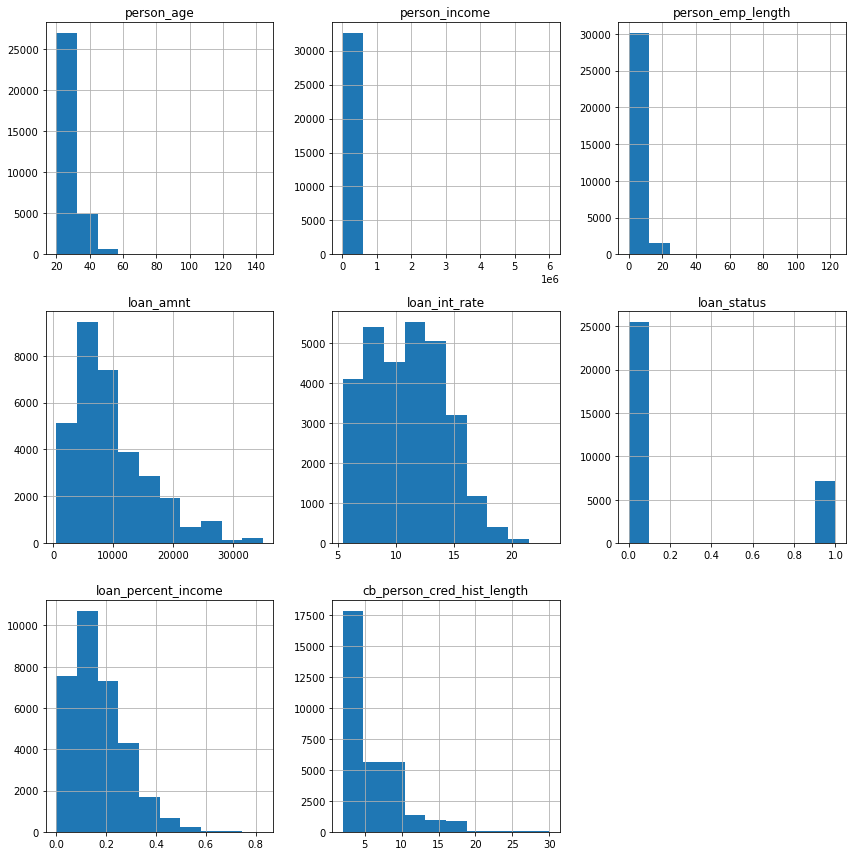

In [9]:
df.hist(figsize = (12,12))
plt.tight_layout()
plt.savefig('images/numeric_dist_plots.png');

* Most people in the data set are in between their 20s and 30s
* Most people stay at a job for less than 10 years. 
* Most of the population has a loan amount of between 50,000 to 100,000
* The percent of the loan to income seems to stay at less than 30 percent. 

## Impute Nulls

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [11]:
iter_imp = IterativeImputer(random_state=42)
df['person_emp_length_imp'] = iter_imp.fit_transform(df[['person_emp_length']]).ravel()

In [12]:
df['loan_int_rate_imp'] = iter_imp.fit_transform(df[['loan_int_rate']]).ravel()

In [13]:
df.drop(columns = ['person_emp_length','loan_int_rate'], inplace = True)

## Deal with Outliers

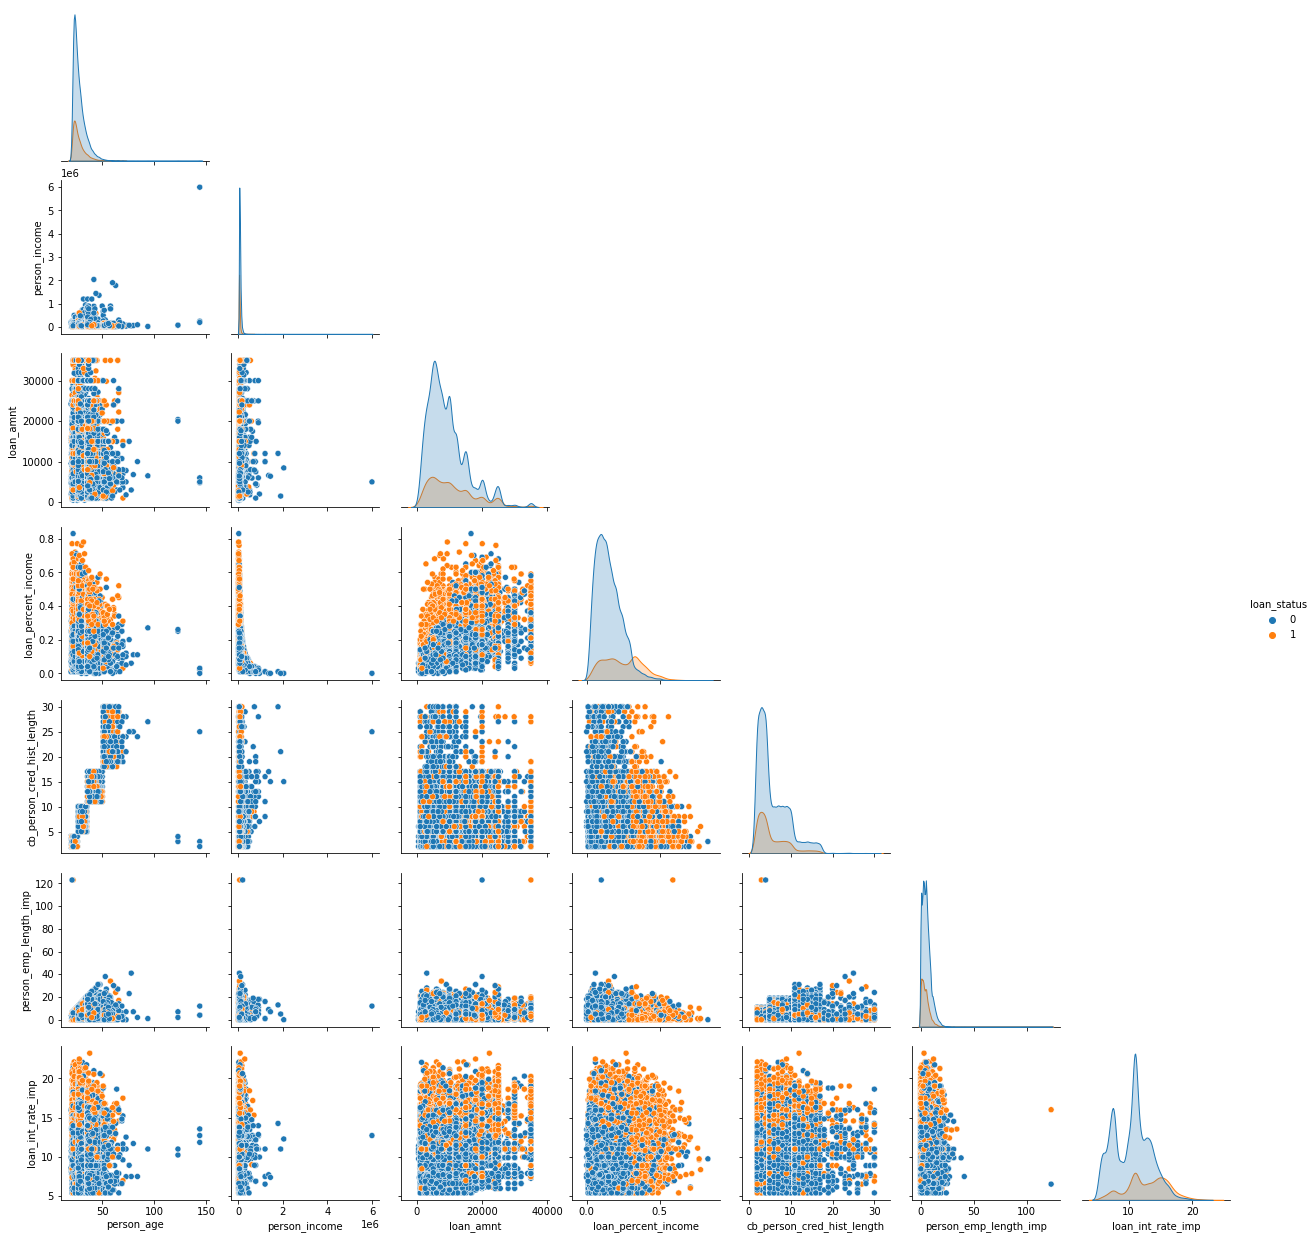

In [14]:
sns.pairplot(data = df,corner = True, hue = 'loan_status');

### Employee Length

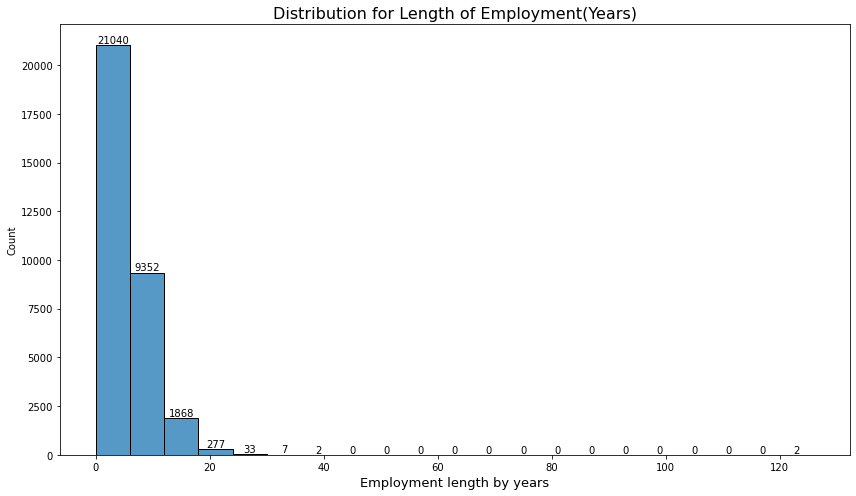

In [15]:
plt.figure(figsize = (12,7))
plt.title('Distribution for Length of Employment(Years)', fontsize = 16)
plt.xlabel('Employment length by years', fontsize = 13)
ax_1 = sns.histplot(x = df['person_emp_length_imp'], binwidth = 6)
for i in ax_1.containers:
    ax_1.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/emp_length_hist_og.png');

* Right skewed heavily due to what appears to be outliers reaching past the 120 year mark.

In [16]:
df['person_emp_length_imp'].describe()

count    32581.000000
mean         4.789686
std          4.085333
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length_imp, dtype: float64

* Most people stay at a job for less than 10 years.
* On average people stay on the job for 4.44 years.

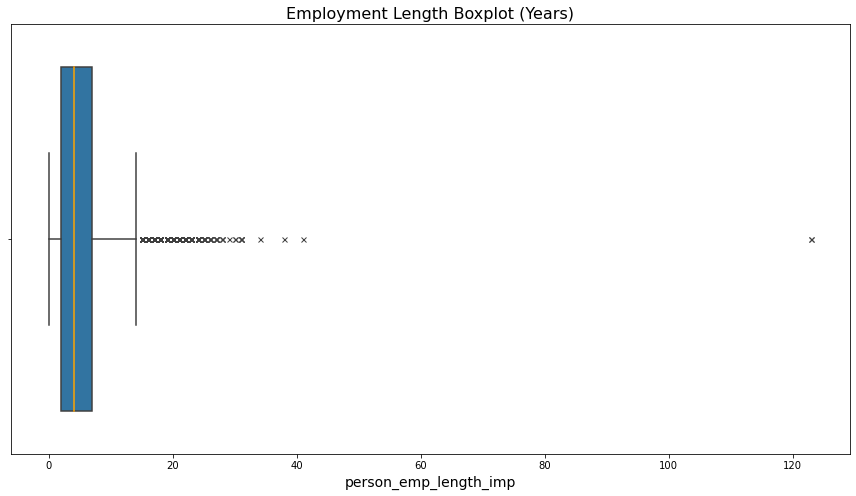

In [17]:
plt.figure(figsize = (12,7))
plt.title('Employment Length Boxplot (Years)', fontsize =16)
plt.xlabel(xlabel='Employment length (Years)',fontsize = 14)
sns.boxplot(x = df['person_emp_length_imp'], flierprops = {'marker':'x'},
            medianprops = {'color':'orange'})

plt.tight_layout()
plt.savefig('images/emp_length_original_boxplot.png');

* Clear outliers occur from about the 20 year mark on, interquartile range calculations can give us a specific threshold by which to eliminate them.

In [18]:
df['person_emp_length_imp'].describe()

count    32581.000000
mean         4.789686
std          4.085333
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length_imp, dtype: float64

In [19]:
# Use interquartile range method to deal with outliers
emp_length_iqr = 7-2
emp_length_cutoff= emp_length_iqr*1.5
upper_emp_length_cutoff = 7 + emp_length_cutoff
emp_length_outliers = df[df['person_emp_length_imp']>upper_emp_length_cutoff]
df.drop(emp_length_outliers.index, inplace= True)

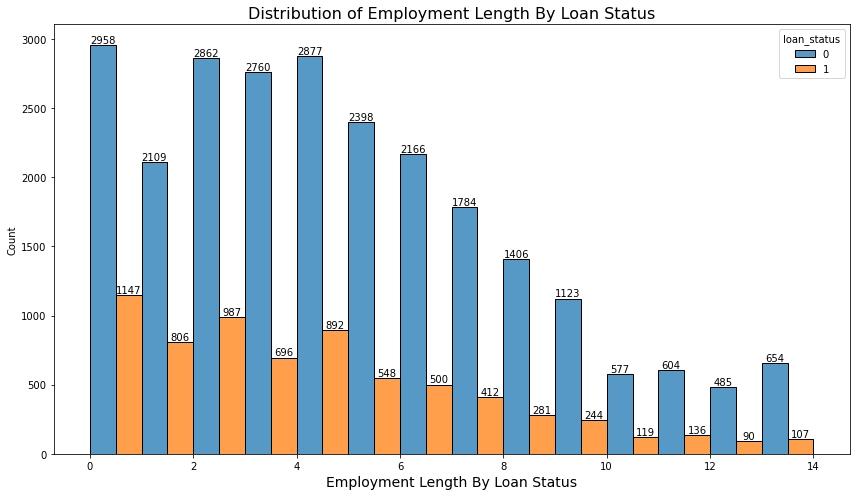

In [20]:
plt.figure(figsize = (12,7))
plt.title('Distribution of Employment Length By Loan Status', fontsize =16)
plt.xlabel('Employment Length By Loan Status', fontsize = 14)
ax_1c = sns.histplot(x = df['person_emp_length_imp'],binwidth = 1,
                     hue = df['loan_status'], multiple = 'dodge')
for i in ax_1c.containers:
    ax_1c.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/person_emp_hist_loan_status.png')


* As we drill down by employee length and loan status, we see both frequency of both populations go down over time at the same about the same proportional rate.  

''

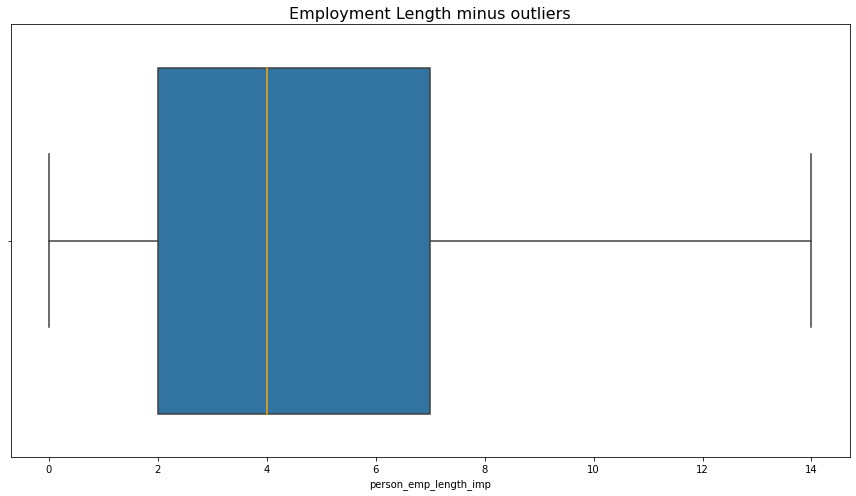

In [21]:
plt.figure(figsize = (12,7))
plt.title('Employment Length minus outliers', fontsize = 16)
sns.boxplot(x = df['person_emp_length_imp'],flierprops = {'marker':'x'},medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/box_emp_length.png')
;

### Personal Income

In [22]:
df['person_income'].sort_values()

31930       4000
15964       4080
27896       4200
15963       4200
15962       4800
          ...   
31924    1440000
32497    1782000
32546    1900000
30049    2039784
32297    6000000
Name: person_income, Length: 31728, dtype: int64

In [23]:
df['person_income'].describe()

count    3.172800e+04
mean     6.549289e+04
std      6.125403e+04
min      4.000000e+03
25%      3.840000e+04
50%      5.500000e+04
75%      7.802400e+04
max      6.000000e+06
Name: person_income, dtype: float64

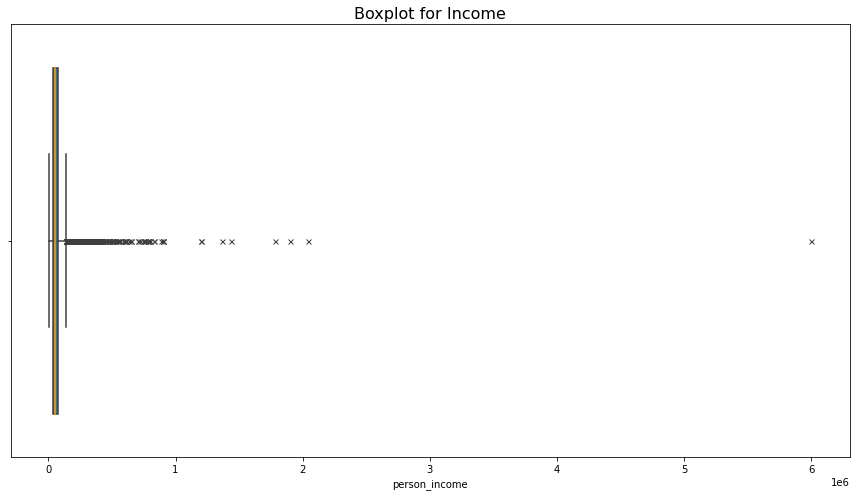

In [24]:
plt.figure(figsize = (12,7))
plt.title('Boxplot for Income', fontsize = 16)
sns.boxplot(x=df['person_income'],flierprops = {'marker':'x'}, medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/person_income_original_boxplot.png');

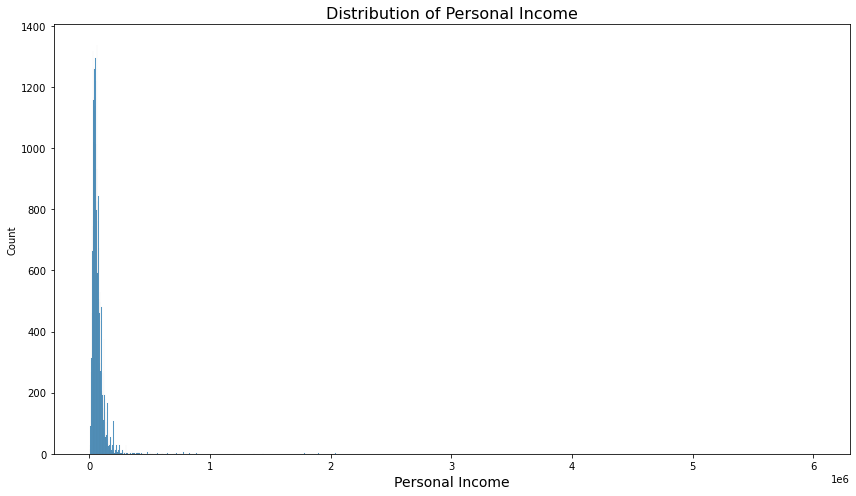

In [25]:
plt.figure(figsize = (12,7))
plt.title('Distribution of Personal Income', fontsize = 16)
plt.xlabel('Personal Income', fontsize = 14)
ax2 = sns.histplot(data = df, x = 'person_income')
plt.tight_layout()
plt.savefig('images/income_dist_original.png')

* Regarding income we can see the economic disparities and the outliers exist by several orders of magnitude.

In [26]:
def outlier_selector(data,cols):
    '''
    data is the data frame
    cols is the corresponding column(str)
    applies techniques to find 25th & 75th percentiles
    calculate the IQR
    Provide lower and upper cutoff points
    '''
    print(data[cols].describe())
#25th & 75th percentiles
    column_25 = np.percentile(data[cols],25)
    column_75 = np.percentile(data[cols],75)
#calculate Interquartile range
    column_iqr = column_75 - column_25
#calculate outlier Cutoff
    column_cutoff = column_iqr * 1.5
#upper & lower cut off points
    upper_cutoff = column_75 + column_cutoff
    lower_cutoff = column_25 - column_cutoff
    outliers = data[data[cols] > upper_cutoff]
    data.drop(outliers.index, inplace = True)
    return(f'upper cutoff: {upper_cutoff}, lower cutoff: {lower_cutoff}')

In [27]:
outlier_selector(df, 'person_income')

count    3.172800e+04
mean     6.549289e+04
std      6.125403e+04
min      4.000000e+03
25%      3.840000e+04
50%      5.500000e+04
75%      7.802400e+04
max      6.000000e+06
Name: person_income, dtype: float64


'upper cutoff: 137460.0, lower cutoff: -21036.0'

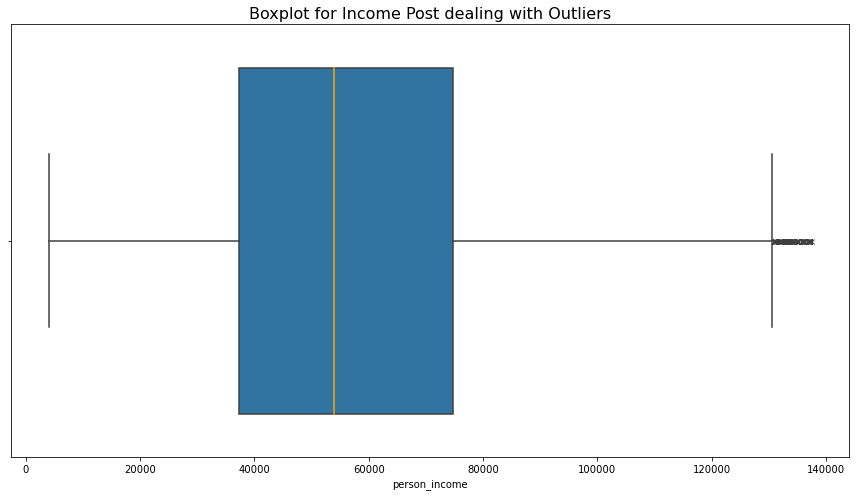

In [28]:
plt.figure(figsize = (12,7))
plt.title('Boxplot for Income Post dealing with Outliers', fontsize = 16)
sns.boxplot(x=df['person_income'],flierprops = {'marker':'x'},medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/person_income_boxplot.png');

* Boxplot gives us a good look at the median income being about 55k

In [29]:
df[['person_income']].describe()

,person_income
count,30171.000000
mean,57980.635876
std,26831.193045
min,4000.000000
25%,37368.000000
50%,54000.000000
75%,74768.000000
max,137400.000000


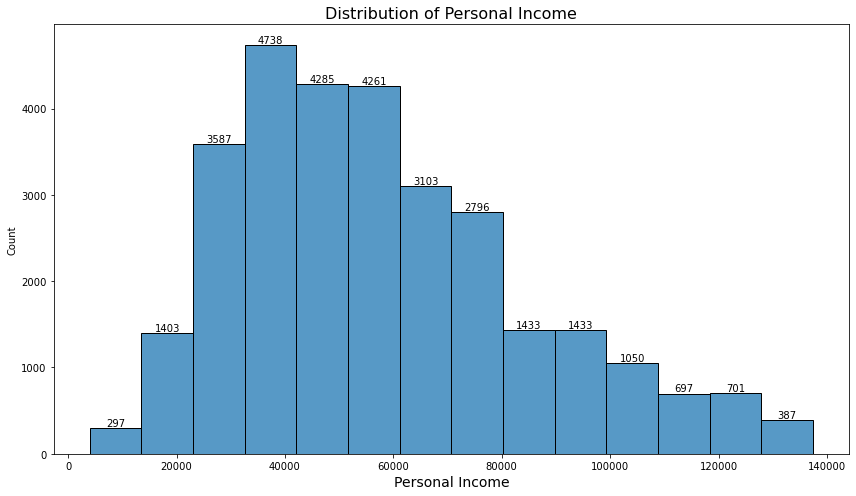

In [30]:
plt.figure(figsize = (12,7))
plt.title('Distribution of Personal Income', fontsize = 16)
plt.xlabel('Personal Income', fontsize = 14)
ax_2a = sns.histplot(data = df, x = 'person_income', bins = 14)
for i in ax_2a.containers:
    ax_2a.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/person_income_distribution.png');

* The data appears to be multimodal and right skewed
* Along with the boxplot we can see that most people in the data set make between 30k and 75k

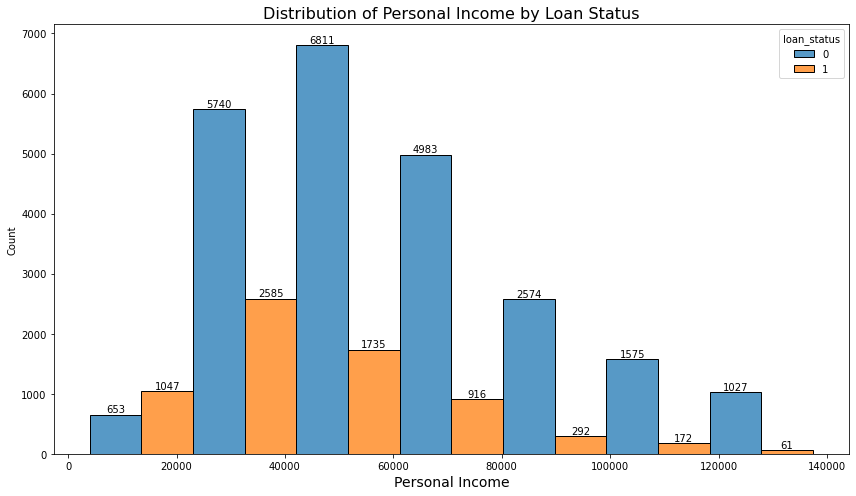

In [31]:
plt.figure(figsize = (12,7))
plt.title('Distribution of Personal Income by Loan Status',fontsize = 16)
plt.xlabel('Personal Income', fontsize = 14)
ax_2b = sns.histplot(x = df['person_income'],hue = df['loan_status'],bins = 7, multiple='dodge')
for i in ax_2b.containers:
    ax_2b.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/person_income_dist_loanstatus.png');

* When looking at the income distribution and breaking down by loan status, we see a sharp decrease in loan defaults for incomes over 80k. 
* Highest defaults occur for incomes between 20 and 40k.  
* Overall there appears to be more people that did not default overall at each income level, with the exception of those making less than 20K. 

### Age

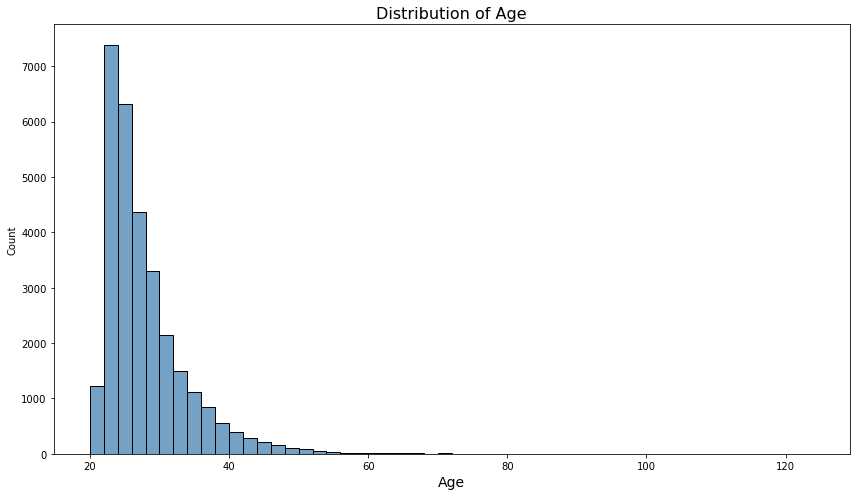

In [32]:
plt.figure(figsize = (12,7))
plt.title("Distribution of Age", fontsize = 16)
plt.xlabel('Age', fontsize = 14)
sns.histplot(data = df, x = 'person_age', binwidth=2, color = 'steelblue')
plt.tight_layout()
plt.savefig('images/age_distribution_original.png');

* This also has a right skew due to ages going past 120. 

In [33]:
df[['person_age']].describe()

,person_age
count,30171.000000
mean,27.366445
std,6.032589
min,20.000000
25%,23.000000
50%,26.000000
75%,30.000000
max,123.000000


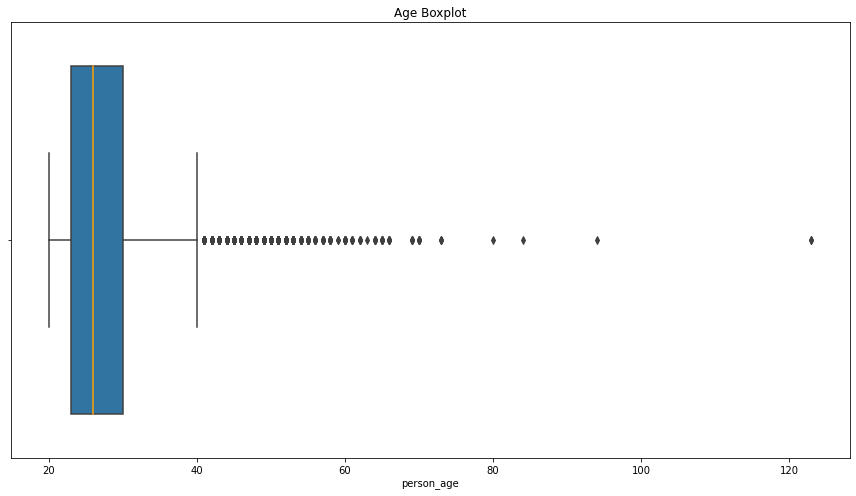

In [34]:
plt.figure(figsize = (12,7))
plt.title('Age Boxplot')
sns.boxplot(x= df['person_age'], medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/age_box_plot.png');

In [35]:
outlier_selector(df,'person_age')

count    30171.000000
mean        27.366445
std          6.032589
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        123.000000
Name: person_age, dtype: float64


'upper cutoff: 40.5, lower cutoff: 12.5'

* Both the box plot & the calculations show that the age cutoff should be 40.5

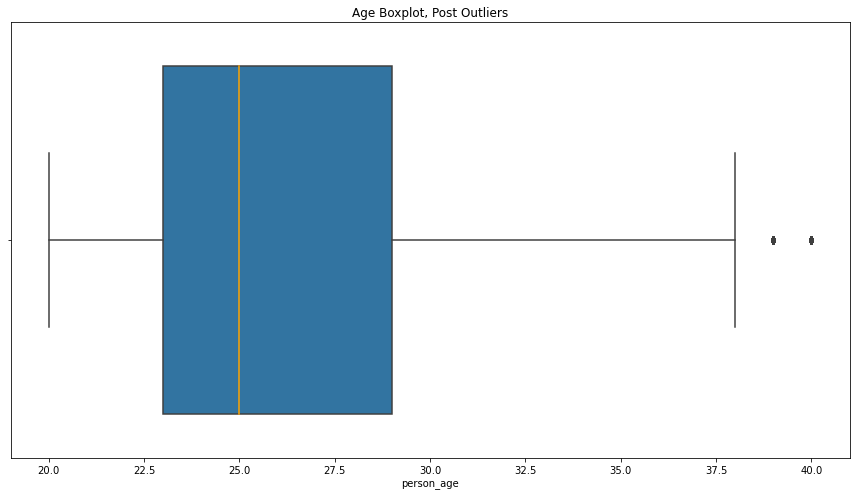

In [36]:
plt.figure(figsize = (12,7))
plt.title('Age Boxplot, Post Outliers')
sns.boxplot(x= df['person_age'],medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/age_box_dropped_outliers.png');

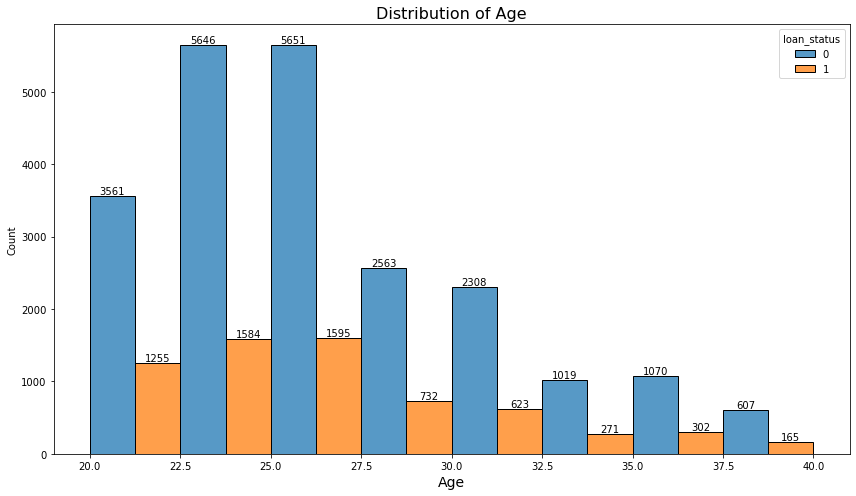

In [37]:
plt.figure(figsize = (12,7))
plt.title("Distribution of Age", fontsize = 16)
plt.xlabel('Age', fontsize = 14)
ax_3 = sns.histplot(data = df, x = 'person_age', bins=8,
            color = 'steelblue', hue = 'loan_status',
             multiple= 'dodge')
for i in ax_3.containers:
    ax_3.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/age_dist_loan_status.png')

* Shows that both populations have an overall decrease as the age increases. 
* However, after age 35 those that default become a bigger portion of the overall population.

### Loan Percent Income

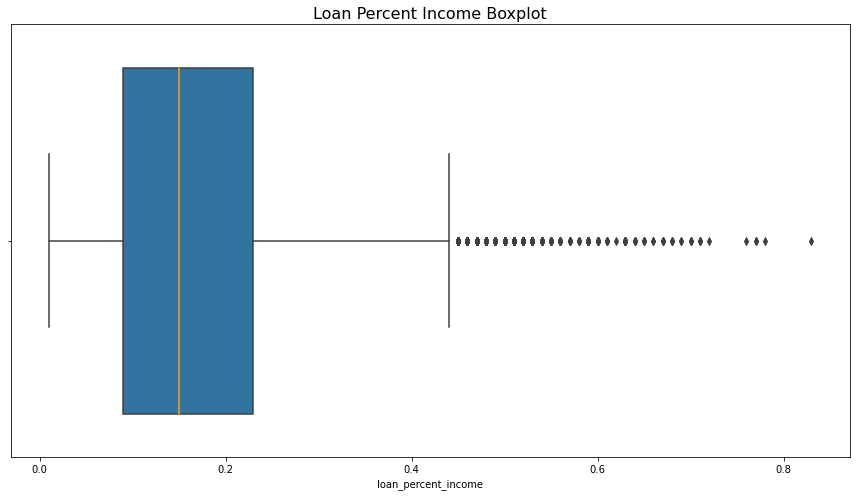

In [38]:
plt.figure(figsize = (12,7))
plt.title("Loan Percent Income Boxplot", fontsize =16)
sns.boxplot(x = df['loan_percent_income'],medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/lpi_box_original.png');

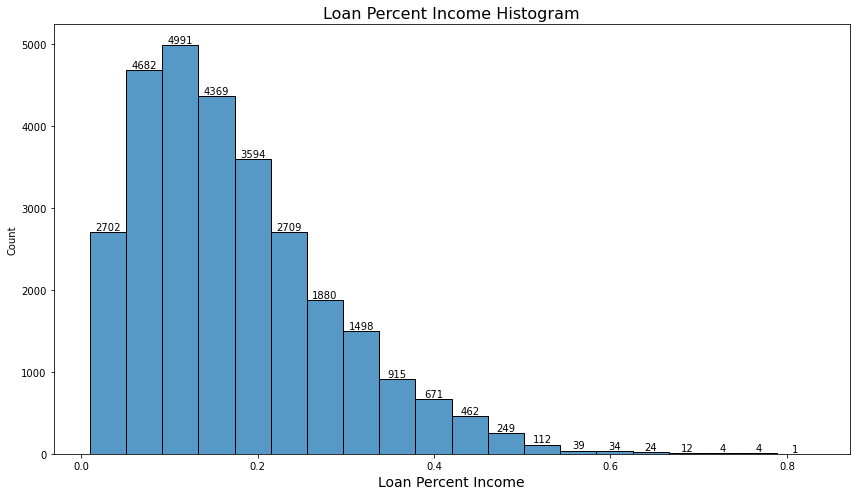

In [43]:
plt.figure(figsize = (12,7))
plt.title("Loan Percent Income Histogram", fontsize = 16)
plt.xlabel("Loan Percent Income", fontsize = 14)
ax_4 = sns.histplot(x= df['loan_percent_income'],bins = 20)
for i in ax_4.containers:
    ax_4.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/lpi_distribution_original.png');

In [44]:
outlier_selector(df, 'loan_percent_income')

count    28952.000000
mean         0.175091
std          0.107170
min          0.010000
25%          0.090000
50%          0.150000
75%          0.230000
max          0.830000
Name: loan_percent_income, dtype: float64


'upper cutoff: 0.44000000000000006, lower cutoff: -0.12000000000000002'

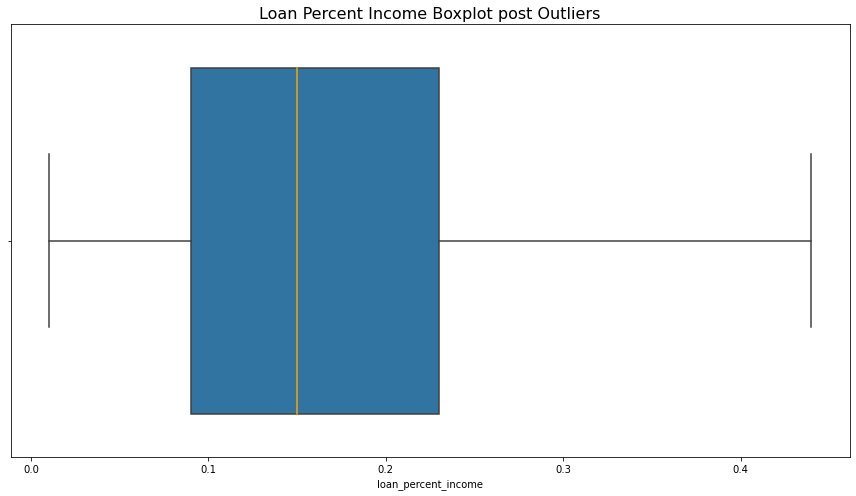

In [45]:
plt.figure(figsize = (12,7))
plt.title("Loan Percent Income Boxplot post Outliers", fontsize = 16)
sns.boxplot(x = df['loan_percent_income'],medianprops = {'color':'orange'})
plt.tight_layout()
plt.savefig('images/lpi_boxplot.png');

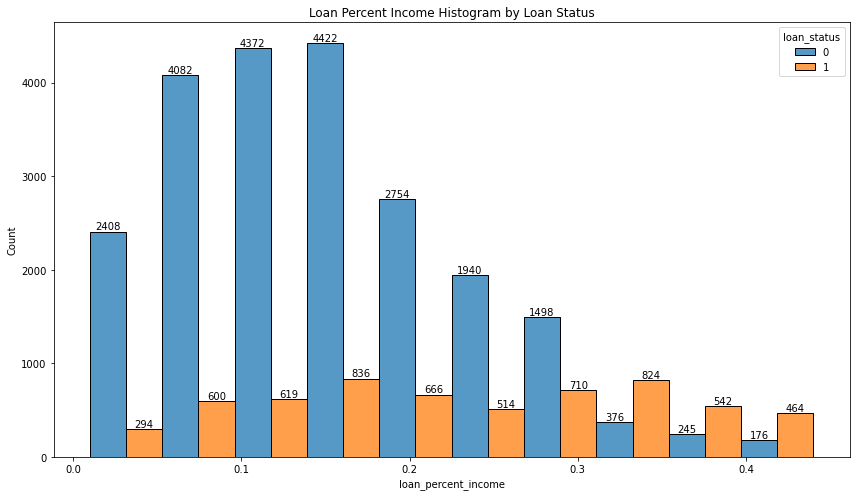

In [48]:
plt.figure(figsize = (12,7))
plt.title('Loan Percent Income Histogram by Loan Status')
ax_4b = sns.histplot(x= df['loan_percent_income'], hue = df['loan_status'],multiple='dodge', bins = 10)
for i in ax_4b.containers:
    ax_4b.bar_label(i, label_type= 'edge')
plt.tight_layout()
plt.savefig('images/lpi_loan_status_dist.png');

* The population whose loan percent income exceeds .3 is dominated by those that default over loans over those that do not.

## Encode/ Dummify non numerical features

In [49]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
person_emp_length_imp         float64
loan_int_rate_imp             float64
dtype: object

In [50]:
df[['person_home_ownership','loan_intent', 'loan_grade', 'cb_person_default_on_file']]

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
1,OWN,EDUCATION,B,N
5,OWN,VENTURE,A,N
7,RENT,MEDICAL,B,N
8,RENT,PERSONAL,A,N
9,OWN,VENTURE,D,N
...,...,...,...,...
32287,RENT,DEBTCONSOLIDATION,D,N
32289,MORTGAGE,HOMEIMPROVEMENT,B,N
32290,MORTGAGE,DEBTCONSOLIDATION,A,N
32293,MORTGAGE,MEDICAL,B,N


In [51]:
from sklearn.preprocessing import OrdinalEncoder

In [52]:
df['loan_grade'].value_counts().index

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='object')

In [53]:
loan_ordinal_enc = OrdinalEncoder(categories = [['G','F','E','D','C','B','A']])
df['loan_grade_ordinal'] = loan_ordinal_enc.fit_transform(df[['loan_grade']])                     

In [54]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].apply(lambda x:1 if x == 'Y' else 0)

In [55]:
df.head()

,person_age,person_income,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_emp_length_imp,loan_int_rate_imp,loan_grade_ordinal
1,21,9600,OWN,EDUCATION,B,1000,0,0.10,0,2,5.0,11.14,5.0
5,21,9900,OWN,VENTURE,A,2500,1,0.25,0,2,2.0,7.14,6.0
7,24,78956,RENT,MEDICAL,B,35000,1,0.44,0,4,5.0,11.11,5.0
8,24,83000,RENT,PERSONAL,A,35000,1,0.42,0,2,8.0,8.90,6.0
9,21,10000,OWN,VENTURE,D,1600,1,0.16,0,3,6.0,14.74,3.0


In [56]:
df = pd.get_dummies(data = df, 
                    columns=['person_home_ownership','loan_intent'],
                    drop_first= True)

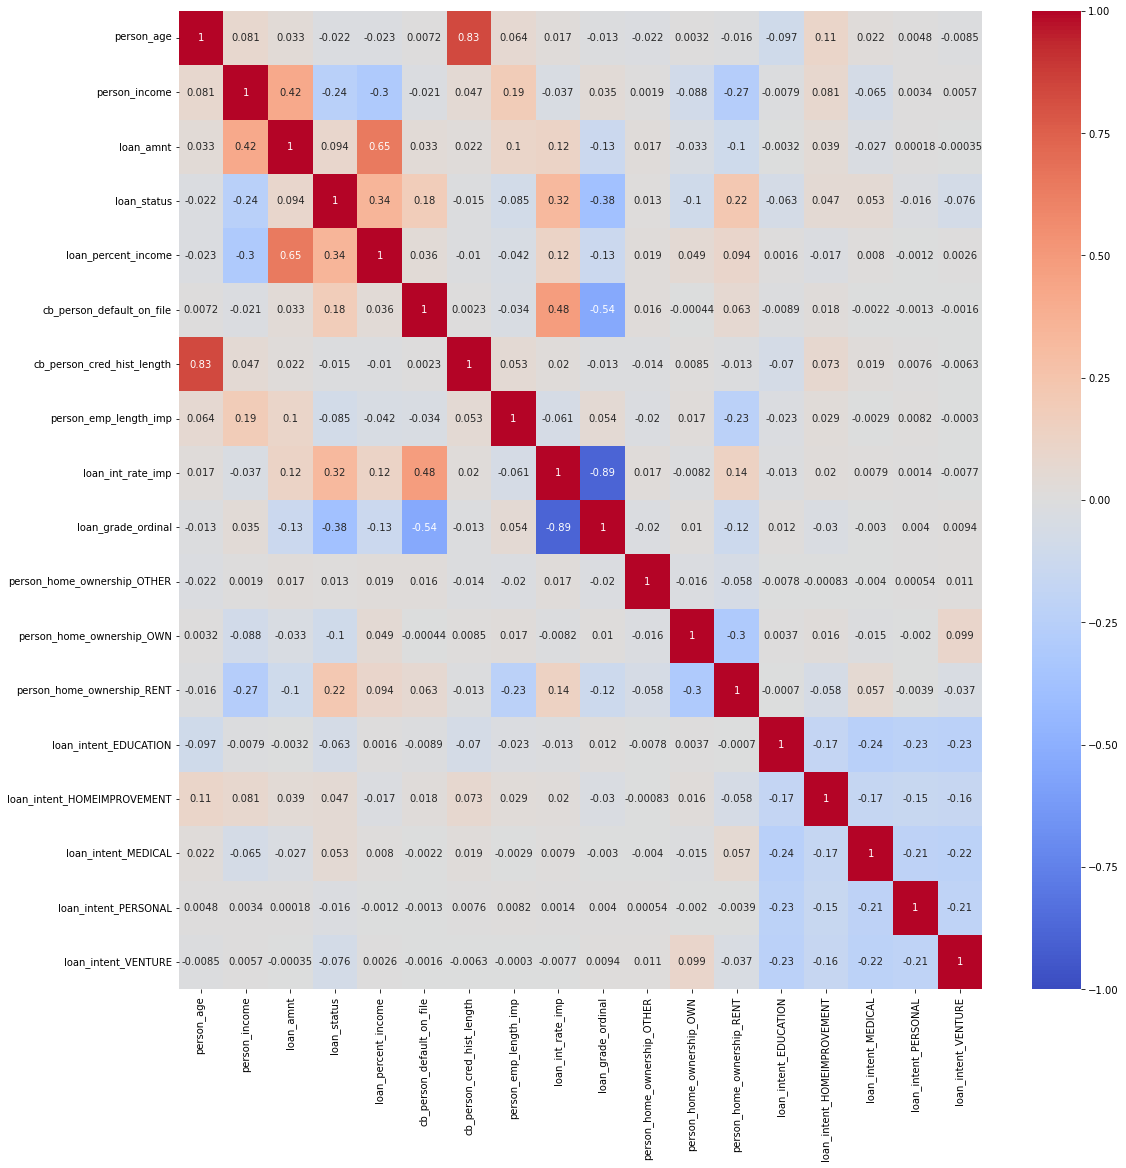

In [57]:
plt.figure(figsize = (18,18))
sns.heatmap(df.corr(),annot = True,
           vmin = -1,
           vmax = 1,
           cmap = 'coolwarm');

* This heat map gives us a way to look at some relationships between our features, and we can do this with some scatterplots.

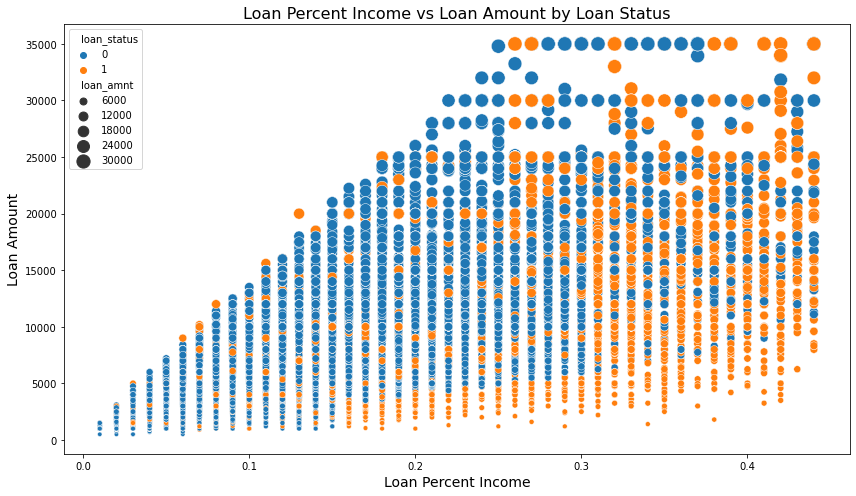

In [74]:
plt.figure(figsize = (12,7))
plt.title('Loan Percent Income vs Loan Amount by Loan Status', fontsize = 16)
plt.xlabel('Loan Percent Income', fontsize = 14)
plt.ylabel('Loan Amount', fontsize = 14)
sns.scatterplot(data = df, x = 'loan_percent_income', y = 'loan_amnt', hue = 'loan_status',
                size = 'loan_amnt', sizes = (20,200))
plt.tight_layout()
plt.savefig('images/lpi_v_loan_amount.png');

* loan amount and loan as a percent of income increase their is alos more variability in the observed data, however when you filter for whether those people defaulted
* You can see the cluster of defaults as soon as the loan percent of income is greater than .15 and loan amount increases.

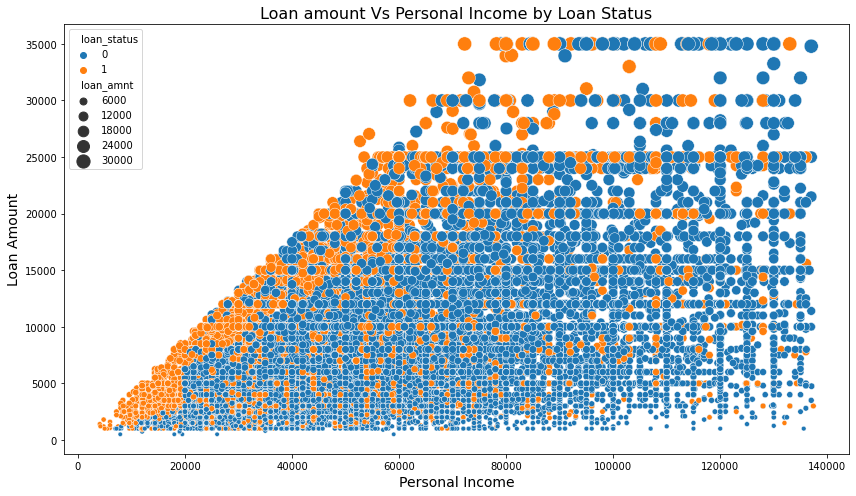

In [76]:
plt.figure(figsize = (12,7))
plt.title('Loan amount Vs Personal Income by Loan Status', fontsize = 16)
plt.xlabel('Personal Income', fontsize = 14)
plt.ylabel('Loan Amount', fontsize = 14)
sns.scatterplot(data = df, x = 'person_income', y = 'loan_amnt', hue = 'loan_status',
                size = 'loan_amnt', sizes = (20,200))
plt.tight_layout();

* Once again the way the data fans out shows variability as income and loan amount increase
* When filtering by loan status we can see that incomes lower than 20k default more. 
* Incomes of less thank 50k and loan amounts between 20k and loan amounts between about 7k & 17k also show a cluster of loan defaults as well.

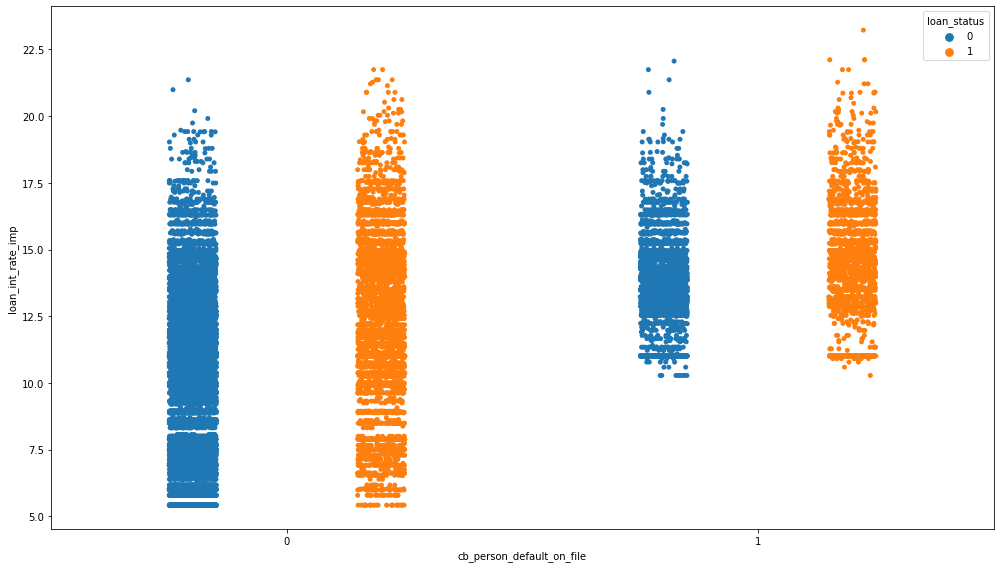

In [78]:
plt.figure(figsize = (12,7))
sns.stripplot(data = df, x = 'cb_person_default_on_file', y = 'loan_int_rate_imp', hue = 'loan_status', dodge = True)
plt.tight_layout();

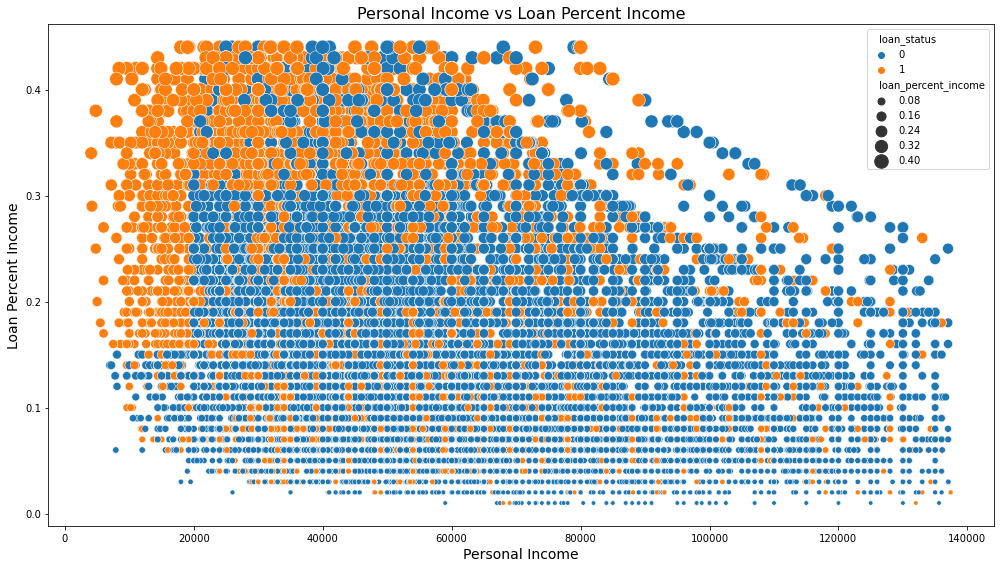

In [87]:
plt.figure(figsize = (12,7))
plt.title('Personal Income vs Loan Percent Income', fontsize = 16)
plt.xlabel('Personal Income', fontsize = 14)
plt.ylabel('Loan Percent Income', fontsize = 14)
sns.scatterplot(data = df, x = 'person_income', y = 'loan_percent_income', hue = 'loan_status',
                size = 'loan_percent_income', sizes = (20,200))
plt.tight_layout()
plt.savefig('images/income_v_lpi.png');

* You have a concentration of people defaulting when there is low income(<20k) and high loan percent income.
* Followed by the area where income is between 20k and 80k but loan percent income is between .03 and .04.

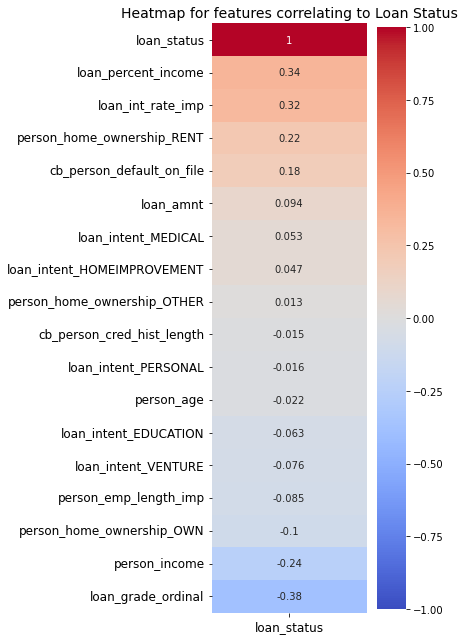

In [94]:
plt.figure(figsize=(6,9))
plt.title('Heatmap for features correlating to Loan Status', fontsize = 14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
sns.heatmap(df.corr()[['loan_status']].sort_values(by = 'loan_status', ascending = False),
           annot = True,
           vmin = -1,
           vmax = 1,
           cmap = 'coolwarm')
plt.tight_layout()
plt.savefig('images/heatmap.png');

**Top 3 correlated features are:**
* Loan percent of Income
* Loan Interest rate
* Person is renting
In other words if your percentage of income is higher, your interest rates are higher, and you are a renter you are more likely to default.

**On the other side of the spectrum:**
* Loan grade (Loan grade of A = 6, B = 5, C = 4, etc)
* Personal Income
* Person owns a home
These features indicate that the better your loan grade, the higher your income, and if you are a home owner will make you less likely to default

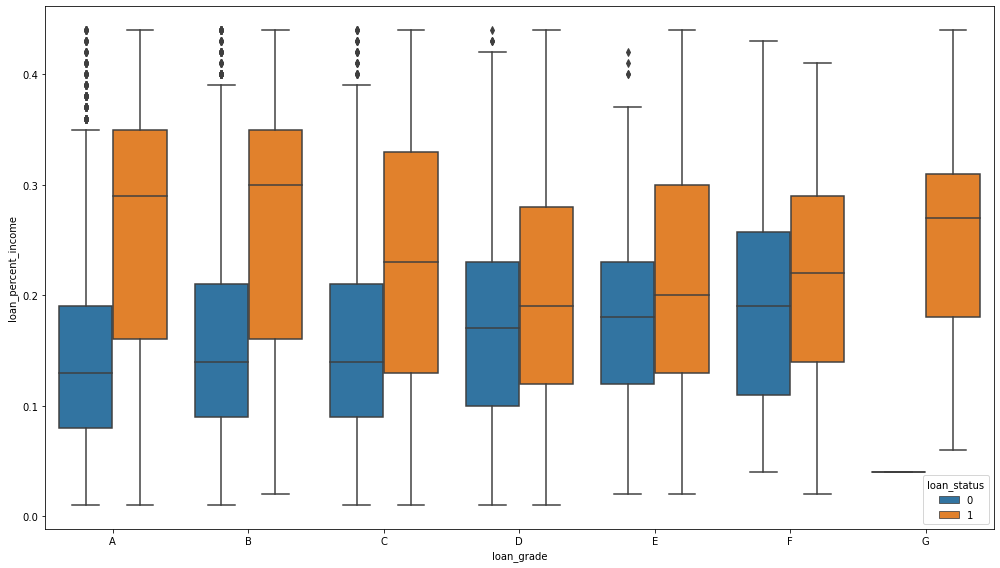

In [69]:
plt.figure(figsize = (12,7))
grade_order = ['A',"B", "C", "D","E","F","G"]
sns.boxplot(data = df, x = 'loan_grade', y = 'loan_percent_income', hue = 'loan_status', order= grade_order)
plt.tight_layout()
plt.savefig('images/grade_loan_percent_income_box.png');

* Across loan_grades we can see the common trend that "the median loan as a percent of income" is always higher for those that default on their loans than those who do not.
* Loan grades D, E & F have a closer loan as a percent of income, but it shows that once it crosses that .2 mark they are more likely to default.
* Loan Grade G shows a median loan percent of income of about .28 and everyone in this category has defaulted.
* Outliers in the sense that for every loan grade, only a few do not default on their loans when the loan percent income is over .35.

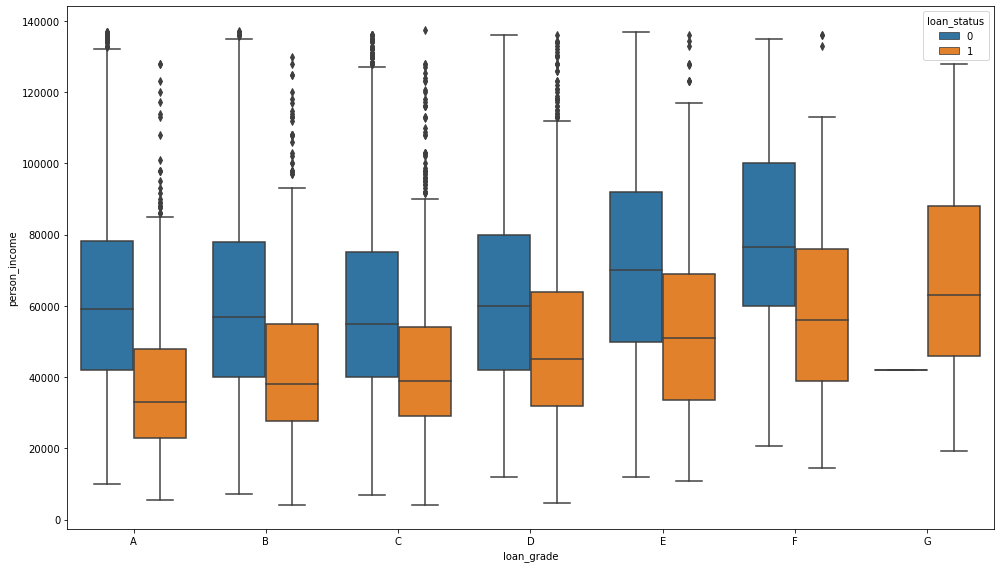

In [70]:
plt.figure(figsize = (12,7))
grade_order = ['A',"B", "C", "D","E","F","G"]
sns.boxplot(data = df, x = 'loan_grade', y = 'person_income', hue = 'loan_status', order= grade_order)
plt.tight_layout()
plt.savefig('images/grade_income_loan_status_box.png');

* For all loan grades, higher incomes tend to determine whether a person will default or not.  
* All grade G loan borrowers have defaulted, even as they had a median income of 60k

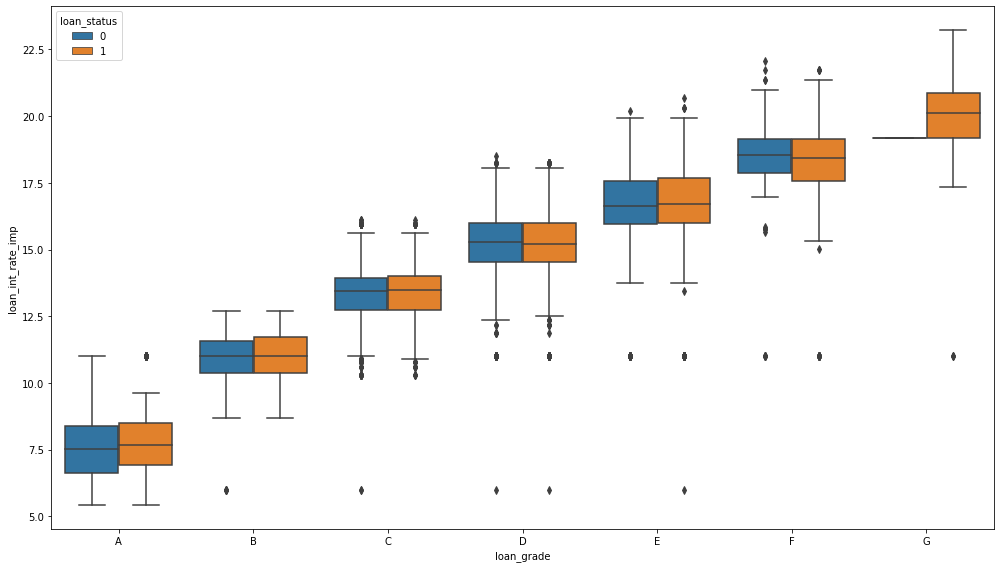

In [79]:
plt.figure(figsize = (12,7))
grade_order = ['A',"B", "C", "D","E","F","G"]
sns.boxplot(data = df, x = 'loan_grade', y = 'loan_int_rate_imp', hue = 'loan_status', order= grade_order)
plt.tight_layout()

* Looks like the average interest rate for a Grade G loan has a median of about 20 percent, on the other end of the spectrum a Grade A loan has a median of about 7.5 percent interest.  The interest rate of 20 percent seems to be a humongous obstacle for borrowers and guarantees they will not be able to pay off the loan.  

In [114]:
mean_loan_grade = df.groupby(by = df['loan_grade']).agg('mean')[['loan_int_rate_imp']]
mean_loan_grade.reset_index(inplace=True)

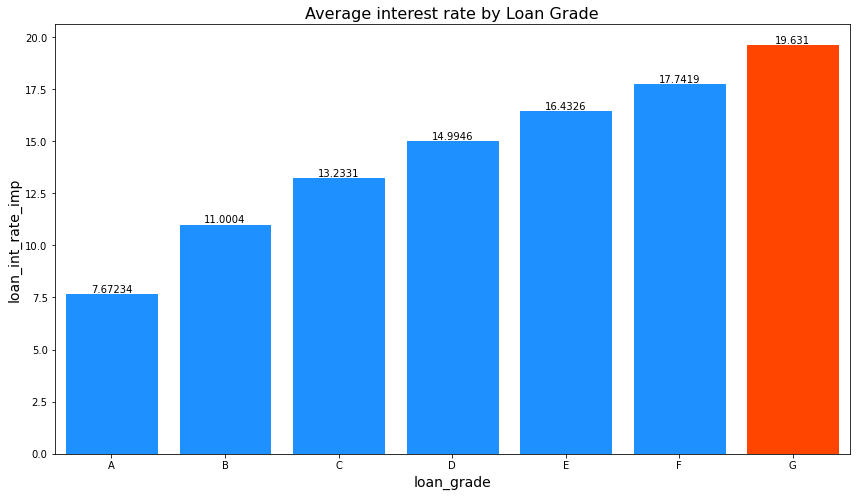

In [123]:
plt.figure(figsize = (12,7))
plt.title("Average interest rate by Loan Grade", fontsize = 16)
plt.xlabel('Loan Interest Rate', fontsize = 14)
plt.ylabel('Loan Grade', fontsize = 14)
ax_5 = sns.barplot(data = mean_loan_grade, x = 'loan_grade', y ='loan_int_rate_imp', color = 'dodgerblue')
for i in ax_5.containers:
    ax_5.bar_label(i, label_type= 'edge')
for bar in ax_5.patches:
    if bar.get_height()>19:
        bar.set_color('orangered')
    else:
        bar.set_color('dodgerblue')
plt.tight_layout()
plt.savefig('images/mean_interest_loan_grade.png');

## Classifying Models

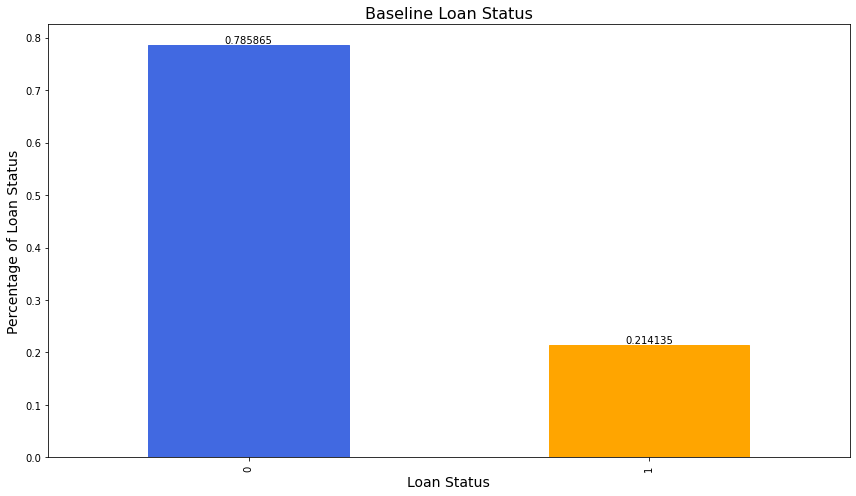

In [151]:
plt.figure(figsize = (12,7))
plt.title('Baseline Loan Status', fontsize = 16)
plt.xlabel('Loan Status', fontsize = 14)
plt.ylabel('Percentage of Loan Status', fontsize = 14)
ax_6 = df['loan_status'].value_counts(normalize= True).plot(kind = 'bar')
for i in ax_6.containers:
    ax_6.bar_label(i, label_type= 'edge')
for bar in ax_6.patches:
    if bar.get_height()>.70:
        bar.set_color('royalblue')
    else:
        bar.set_color('orange')
plt.tight_layout()
plt.savefig('images/Loan_status_percentage.png');

### Logistic Regression